In [1]:
# 기본 사용 library import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 분류모델 기본 library import
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

# base model import
import xgboost as xgb
import lightgbm as lgb

# model과 사용되는 library import
from tqdm import tqdm
import joblib

In [2]:
## working directory 설정
new_working_directory = "/Users/hyunbin/Library/CloudStorage/OneDrive-Personal/05 빅데이터 전문가 과정/01 통계 데이터 사이언스/00 팀플/final/new"
os.chdir(new_working_directory)

print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/hyunbin/Library/CloudStorage/OneDrive-Personal/05 빅데이터 전문가 과정/01 통계 데이터 사이언스/00 팀플/final/new


# 가. 데이터 불러오기

In [3]:
train_raw = pd.read_csv("./00 data/train_trd_timeline.csv")
tbill = pd.read_csv("./00 data/tbill_15_mod.csv")

In [4]:
## 원본데이터 보호
train_data = train_raw.copy()

# 나. 수익률 계산하기

In [5]:
## 날짜 데이터 타입을 datetime으로 통일
train_data['issue_d'] = pd.to_datetime(train_data['issue_d'], errors='coerce')
tbill['observation_date'] = pd.to_datetime(tbill['observation_date'], errors='coerce')


## train_data와 tbill을 'issue_d'와 'observation_date'를 기준으로 병합
train_data = pd.merge(train_data, tbill,
                       left_on='issue_d', right_on='observation_date',
                       how='left')

## data frame 정비
train_data = train_data.rename(columns={'DTB3': 'rf_rate'})  # 'DTB3' 컬럼 이름을 'rf_rate'로 변경
train_data = train_data.drop(columns=['issue_d', 'observation_date'], errors='ignore')  # 'issue_d'와 'observation_date' 열 삭제


/var/folders/yb/vl5rylzx0dv4gxwytw3c2h080000gn/T/ipykernel_4754/1174221417.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['issue_d'] = pd.to_datetime(train_data['issue_d'], errors='coerce')
/var/folders/yb/vl5rylzx0dv4gxwytw3c2h080000gn/T/ipykernel_4754/1174221417.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tbill['observation_date'] = pd.to_datetime(tbill['observation_date'], errors='coerce')


In [6]:
## 수익률 산출
train_data['earning_rate'] = train_data['int_rate']-train_data['rf_rate']
train_data = train_data.drop(columns=['rf_rate'], errors='ignore')

## 소수 셋째자리에서 반올림
train_data['earning_rate'] = train_data['earning_rate'].round(3)

# 다. 모델 돌리기

In [7]:
## loan_status 확인
train_data["loan_status"].value_counts()

loan_status
0    824123
1    197245
Name: count, dtype: int64

In [8]:
## random seed 설정
RANDOM_SEED = 40

In [9]:
## 데이터 준비
X = train_data.drop('loan_status', axis=1)
y = train_data['loan_status']

# bool타입 정수형으로
# XGBoost가 bool type를 처리할 때 문제를 발생시키는 경우가 있음
bool_columns = X.select_dtypes(include=['bool']).columns.tolist()
X[bool_columns] = X[bool_columns].astype(int)

# train, validation, test 구분
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2/0.8, random_state=RANDOM_SEED, stratify=y_train)

# earning_rate열 drop 시키기
X_train = X_train.drop('earning_rate', axis=1)
X_valid = X_valid.drop('earning_rate', axis=1)
X_test_ = X_test.copy() # earning_rate 뽑아내기 위한 것
X_test = X_test.drop('earning_rate', axis=1)

# 출력해서 확인
print(f"Train set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_valid.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Train set size: 612820 rows
Validation set size: 204274 rows
Test set size: 204274 rows


## 다-1. XGBoost

### 다-1-1. initial training

#### 다-1-1-1. training

In [10]:
## DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest  = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': RANDOM_SEED
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [11]:
## 모델 학습
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-logloss:0.37134	valid-logloss:0.37169
[1]	train-logloss:0.31775	valid-logloss:0.31839
[2]	train-logloss:0.28580	valid-logloss:0.28664
[3]	train-logloss:0.26549	valid-logloss:0.26654
[4]	train-logloss:0.25205	valid-logloss:0.25332
[5]	train-logloss:0.24310	valid-logloss:0.24455
[6]	train-logloss:0.23690	valid-logloss:0.23859
[7]	train-logloss:0.23264	valid-logloss:0.23454
[8]	train-logloss:0.22965	valid-logloss:0.23182
[9]	train-logloss:0.22755	valid-logloss:0.22990
[10]	train-logloss:0.22597	valid-logloss:0.22850
[11]	train-logloss:0.22484	valid-logloss:0.22752
[12]	train-logloss:0.22389	valid-logloss:0.22676
[13]	train-logloss:0.22325	valid-logloss:0.22626
[14]	train-logloss:0.22264	valid-logloss:0.22592
[15]	train-logloss:0.22202	valid-logloss:0.22551
[16]	train-logloss:0.22154	valid-logloss:0.22525
[17]	train-logloss:0.22105	valid-logloss:0.22498
[18]	train-logloss:0.22073	valid-logloss:0.22486
[19]	train-logloss:0.22025	valid-logloss:0.22459
[20]	train-logloss:0.21989	val

#### 다-1-1-2. feature importance visualization

In [12]:
## 01.feature importance dataframe 설정
xgb_importance_df = pd.DataFrame({
    'Feature': list(xgb_model.get_score(importance_type='weight').keys()),
    'Importance': list(xgb_model.get_score(importance_type='weight').values())
}).sort_values(by='Importance', ascending=False)

## 02. 도메인 feature 필터링 (데이터에 존재하는 것만)
domain_features = ['emp_length', 'dti', 'revol_util', 'fico_avg']
existing_domain_features = [
    feat for feat in domain_features if feat in xgb_importance_df['Feature'].values
]

## 03. 중요도 상위 feature (도메인 feature 제외)
top_features = xgb_importance_df[
    ~xgb_importance_df['Feature'].isin(domain_features)  # 도메인 feature 제외
].head(30 - len(existing_domain_features))  # 최대 20 - (이미 선택된 도메인 feature 수) 개

## 04. 최종 feature 결합 (도메인 feature + 중요도 상위 feature)
selected_features = existing_domain_features + top_features['Feature'].tolist()
print("최종 선택된 feature 갯수", len(selected_features))
print("최종 선택된 Top 30 Features:", selected_features)

## 05. 선택된 feature에 해당하는 데이터프레임 생성 (중요도 순으로)
df_top30 = xgb_importance_df[xgb_importance_df['Feature'].isin(selected_features)]
df_top30 = df_top30.sort_values(by='Importance', ascending=False)

최종 선택된 feature 갯수 30
최종 선택된 Top 30 Features: ['emp_length', 'dti', 'revol_util', 'fico_avg', 'last_fico_range_high', 'int_rate', 'annual_inc', 'installment', 'bc_open_to_buy', 'revol_bal', 'avg_cur_bal', 'total_bc_limit', 'total_rev_hi_lim', 'bc_util', 'total_acc', 'num_il_tl', 'sub_grade', 'num_bc_tl', 'num_rev_accts', 'pct_tl_nvr_dlq', 'total_il_high_credit_limit', 'acc_open_past_24mths', 'total_bal_ex_mort', 'tot_cur_bal', 'tot_hi_cred_lim', 'funded_amnt_inv', 'funded_amnt', 'term', 'mort_acc', 'num_bc_sats']


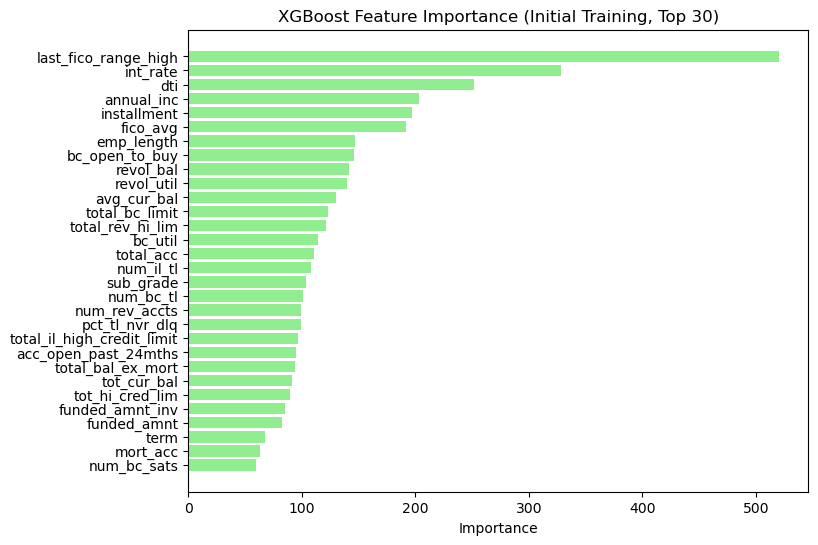

In [13]:
## feature importance visualization
def plot_feature_importance(df, title, color='skyblue'):
    plt.figure(figsize=(8, 6))
    plt.barh(df['Feature'], df['Importance'], color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance(df_top30, "XGBoost Feature Importance (Initial Training, Top 30)", 'lightgreen')

### 다-1-2. Re-trainig

#### 다-1-2-1. training

In [14]:
## 01.feature importance dataframe 설정
def get_selected_features(xgb_model, domain_features=['dti', 'revol_util', 'fico_avg']):
    """
    feature importance를 계산하고, 상위 특징(도메인 특징 포함)을 선택합니다,
    selected features를 return
    """
    ## 01. feature importance dataframe 설정
    xgb_importance_df = pd.DataFrame({
        'Feature': list(xgb_model.get_score(importance_type='weight').keys()),
        'Importance': list(xgb_model.get_score(importance_type='weight').values())
    }).sort_values(by='Importance', ascending=False)

    ## 02. 도메인 feature 필터링 (데이터에 존재하는 것만)
    existing_domain_features = [
        feat for feat in domain_features if feat in xgb_importance_df['Feature'].values
    ]

    ## 03. 중요도 상위 feature (도메인 feature 제외)
    top_features = xgb_importance_df[
        ~xgb_importance_df['Feature'].isin(domain_features)  # 도메인 feature 제외
    ].head(30 - len(existing_domain_features))  # 최대 30 - (이미 선택된 도메인 feature 수) 개

    ## 04. 최종 feature 결합 (도메인 feature + 중요도 상위 feature)
    selected_features = existing_domain_features + top_features['Feature'].tolist()
    return selected_features

##  02 selected features 활용하여 새로운 X, y 만들기
def create_datasets_with_selected_features(X, y, selected_features, test_size=0.2, valid_size=0.25, random_state=42):
    """
    선택된 기능만으로 학습, 검증 및 테스트 데이터셋을 만든다.

    Args:
        X: Original feature DataFrame.
        y: Original target Series.
        selected_features: 선택된 기능 목록.
        test_size: 테스트 세트에 사용할 데이터의 비율
        valid_size: 검증에 사용할 훈련 데이터의 비율
                     (참고: 전체 유효 크기는 유효한_size * (1-검정_size))
        random_state: 재현성을 위한 랜덤 시드

    Returns:
      X_train, X_valid, X_test, y_train, y_valid, y_test
    """
    # X feature 선택
    if not all(feature in X.columns for feature in selected_features):
        missing_features = [feature for feature in selected_features if feature not in X.columns]
        raise ValueError(f"The following features are not present in X: {missing_features}")
    
    X_selected = X[selected_features]


    # Train/test split (initial split의 결과와 동일하게)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X_selected, y, test_size=test_size, random_state=random_state
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_temp, y_train_temp, test_size=valid_size, random_state=random_state
    )

    return X_train, X_valid, X_test, y_train, y_valid, y_test

## 03 XGBoost Model training 시키기
def train_xgboost_model(X_train, y_train, X_valid, y_valid, params=None, num_boost_round=500):

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    if params is None:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': ['logloss', 'auc'],
            'random_state': RANDOM_SEED
        }

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round,
                      evals=watchlist,
                      verbose_eval=True)
    return model

In [15]:
## selected features
selected_features = get_selected_features(xgb_model)


## selected features를 사용하여 새로운 train, val, test 만들기
X_train, X_valid, X_test, y_train, y_valid, y_test = create_datasets_with_selected_features(
    X, y, selected_features
)

# selected features를 사용해서 xgb train
new_xgb_model = train_xgboost_model(X_train, y_train, X_valid, y_valid)

[0]	train-logloss:0.37148	train-auc:0.94186	valid-logloss:0.37216	valid-auc:0.94143
[1]	train-logloss:0.31795	train-auc:0.94326	valid-logloss:0.31879	valid-auc:0.94270
[2]	train-logloss:0.28612	train-auc:0.94398	valid-logloss:0.28711	valid-auc:0.94330
[3]	train-logloss:0.26587	train-auc:0.94459	valid-logloss:0.26702	valid-auc:0.94378
[4]	train-logloss:0.25244	train-auc:0.94498	valid-logloss:0.25386	valid-auc:0.94403
[5]	train-logloss:0.24356	train-auc:0.94531	valid-logloss:0.24522	valid-auc:0.94420
[6]	train-logloss:0.23750	train-auc:0.94565	valid-logloss:0.23934	valid-auc:0.94450
[7]	train-logloss:0.23329	train-auc:0.94603	valid-logloss:0.23538	valid-auc:0.94475
[8]	train-logloss:0.23033	train-auc:0.94637	valid-logloss:0.23263	valid-auc:0.94499
[9]	train-logloss:0.22824	train-auc:0.94669	valid-logloss:0.23073	valid-auc:0.94524
[10]	train-logloss:0.22670	train-auc:0.94703	valid-logloss:0.22942	valid-auc:0.94544
[11]	train-logloss:0.22556	train-auc:0.94727	valid-logloss:0.22851	valid-au

#### 다-1-2-2. feature importance visualization

In [16]:
## feature importance 저장 df 만들기
new_xgb_importance_df = pd.DataFrame({
    'Feature': list(new_xgb_model.get_score(importance_type='weight').keys()),
    'Importance': list(new_xgb_model.get_score(importance_type='weight').values())
}).sort_values(by='Importance', ascending=False)

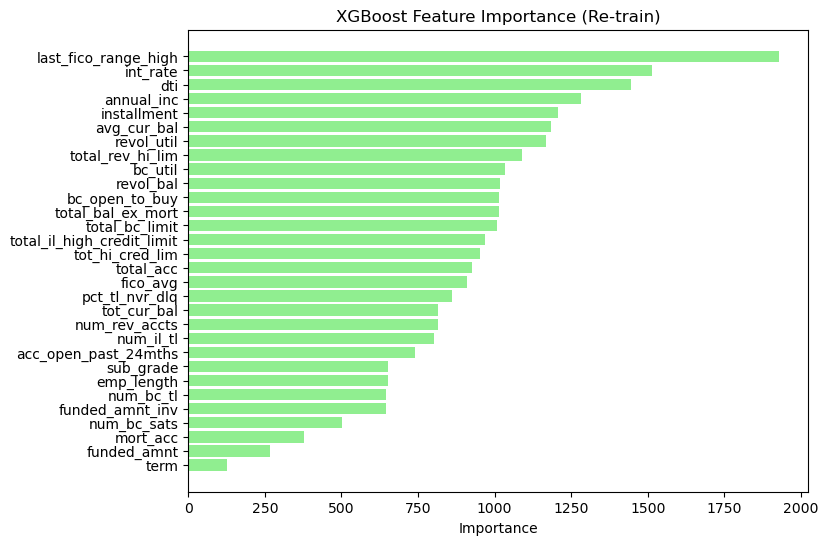

In [17]:
## feature importance visualizaton
def plot_feature_importance(df, title, color='skyblue'):
    plt.figure(figsize=(8, 6))
    plt.barh(df['Feature'], df['Importance'], color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance(new_xgb_importance_df, "XGBoost Feature Importance (Re-train)", 'lightgreen')

### 다-1-3. threshold tuning

In [18]:
## 목적함수 : 초과수익률 최대화
def custom_objective(y_true, y_pred_proba, earning_rate):
    """
    사용자 정의 목적 함수.
    (TN의 earning rate) - (FN의 earning rate)를 최대화.  FP는 고려하지 않음.

    Args:
        y_true: 실제 레이블 (0 또는 1).  pandas Series.
        y_pred_proba: 예측 확률 (XGBoost의 predict 결과). numpy array.
        earning_rate: 각 샘플의 earning rate. pandas Series.

    Returns:
        최적 threshold, 최대화된 목적 함수 값.
    """

    best_threshold = 0
    max_objective = -np.inf
    thresholds = np.linspace(0, 1, 101)

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)

        # y_true, y_pred, 그리고 earning_rate가 호환되는 모양과 유형을 가지는지 확인
        if isinstance(y_true, pd.Series):
             y_true = y_true.values  # y_true -> numpy array
        if isinstance(earning_rate, pd.Series):
            earning_rate = earning_rate.values # earning_rate -> numpy array


        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # 목적함수
        objective = (
            ((y_true == 0) & (y_pred == 0)).dot(earning_rate)
             - ((y_true == 1) & (y_pred == 0)).dot(earning_rate)
        )


        if objective > max_objective:
            max_objective = objective
            best_threshold = threshold

    return best_threshold, max_objective



In [19]:
## test data에 대해 예측 진행
X_test_for_prediction = X_test[selected_features]
dtest_final = xgb.DMatrix(X_test_for_prediction)
y_pred_prob_xgb = new_xgb_model.predict(dtest_final)

earning_rate_test = X_test_['earning_rate']

# 목적 함수를 사용하여 최적 threshold 찾기
best_threshold_xgb, max_objective_xgb = custom_objective(y_test, y_pred_prob_xgb, earning_rate_test)

In [20]:
## 결과 확인
# 최적 임계치를 사용하여 최종 예측
print(f"Best Threshold: {best_threshold_xgb}")
print(f"Maximized Objective: {max_objective_xgb}")

# classification report
y_pred_final_xgb = (y_pred_prob_xgb >= best_threshold_xgb).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final_xgb))

# Confusion Matrix
conf_matrix_final_xgb = confusion_matrix(y_test, y_pred_final_xgb)
print("\nFinal Confusion Matrix (Labeled):")
print("                 Predicted Negative (0)   Predicted Positive (1)")
print(f"Actual Negative (0)      {conf_matrix_final_xgb[0, 0]} (TN)             {conf_matrix_final_xgb[0, 1]} (FP)")
print(f"Actual Positive (1)      {conf_matrix_final_xgb[1, 0]} (FN)             {conf_matrix_final_xgb[1, 1]} (TP)")

print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_final_xgb)))

## 종합 평가지표 계산
accuracy = accuracy_score(y_test, y_pred_final_xgb)
precision = precision_score(y_test, y_pred_final_xgb)
recall = recall_score(y_test, y_pred_final_xgb)
f1 = f1_score(y_test, y_pred_final_xgb)

print("\nOverall Metrics:")
print("Accuracy:  {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall:    {:.4f}".format(recall))
print("F1 Score:  {:.4f}".format(f1))

Best Threshold: 0.51
Maximized Objective: 1824159.799999922

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    164891
           1       0.76      0.73      0.74     39383

    accuracy                           0.90    204274
   macro avg       0.85      0.84      0.84    204274
weighted avg       0.90      0.90      0.90    204274


Final Confusion Matrix (Labeled):
                 Predicted Negative (0)   Predicted Positive (1)
Actual Negative (0)      155611 (TN)             9280 (FP)
Actual Positive (1)      10604 (FN)             28779 (TP)
Test Accuracy: 0.9027

Overall Metrics:
Accuracy:  0.9027
Precision: 0.7562
Recall:    0.7307
F1 Score:  0.7432


In [21]:
## 모델과 최적 임계치 저장 (모델과 threshold를 dictionary로 묶어서 저장)
model_dir = "./02 model"
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join(model_dir, "default_pred_xgb.pkl")

saved_obj = {
    "model": xgb_model,
    "best_threshold": best_threshold_xgb
}
joblib.dump(saved_obj, save_path)
print(f"Model and threshold saved to {save_path}")


Model and threshold saved to ./02 model/default_pred_xgb.pkl


## 다-2. lightGBM

### 다-2-1. initial training

#### 다-2-1-1. training

In [22]:
## Dataset 생성
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
lgb_params = {
    'objective': 'binary',          # 이진 분류
    'metric': 'binary_logloss',     # 평가 지표
    'seed': RANDOM_SEED
}

In [23]:
## 모델 학습
lgb_model = lgb.train(
    lgb_params,
    dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dvalid],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

[LightGBM] [Info] Number of positive: 118314, number of negative: 494506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5074
[LightGBM] [Info] Number of data points in the train set: 612820, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193065 -> initscore=-1.430217
[LightGBM] [Info] Start training from score -1.430217
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[154]	train's binary_logloss: 0.215415	valid's binary_logloss: 0.222915


#### 다-2-1-2. feature importance visualization

In [24]:
## 01.feature importance dataframe 설정
lgb_importance_df = pd.DataFrame({
    'Feature': lgb_model.feature_name(),
    'Importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values(by='Importance', ascending=False)

## 02. 도메인 feature 필터링 (데이터에 존재하는 것만)
domain_features = ['emp_length', 'dti', 'revol_util', 'fico_avg']
existing_domain_features = [
    feat for feat in domain_features if feat in lgb_importance_df['Feature'].values
]

## 03. 중요도 상위 feature (도메인 feature 제외)
top_features = lgb_importance_df[
    ~lgb_importance_df['Feature'].isin(domain_features)
].head(30 - len(existing_domain_features))

## 04. 최종 feature 결합 (도메인 feature + 중요도 상위 feature)
selected_features = existing_domain_features + top_features['Feature'].tolist()
print("최종 선택된 feature 개수:", len(selected_features))
print("최종 선택된 Top Features:", selected_features)


## 05. 선택된 feature에 해당하는 데이터프레임 생성 (중요도 순으로)
df_top = lgb_importance_df[lgb_importance_df['Feature'].isin(selected_features)]
df_top = df_top.sort_values(by='Importance', ascending=False)

최종 선택된 feature 개수: 30
최종 선택된 Top Features: ['emp_length', 'dti', 'revol_util', 'fico_avg', 'last_fico_range_high', 'term', 'int_rate', 'installment', 'funded_amnt_inv', 'annual_inc', 'bc_open_to_buy', 'sub_grade', 'funded_amnt', 'num_rev_accts', 'total_rev_hi_lim', 'total_acc', 'pct_tl_nvr_dlq', 'avg_cur_bal', 'total_bc_limit', 'num_bc_tl', 'bc_util', 'tot_cur_bal', 'revol_bal', 'num_bc_sats', 'mort_acc', 'total_bal_ex_mort', 'acc_open_past_24mths', 'tot_hi_cred_lim', 'num_il_tl', 'total_il_high_credit_limit']


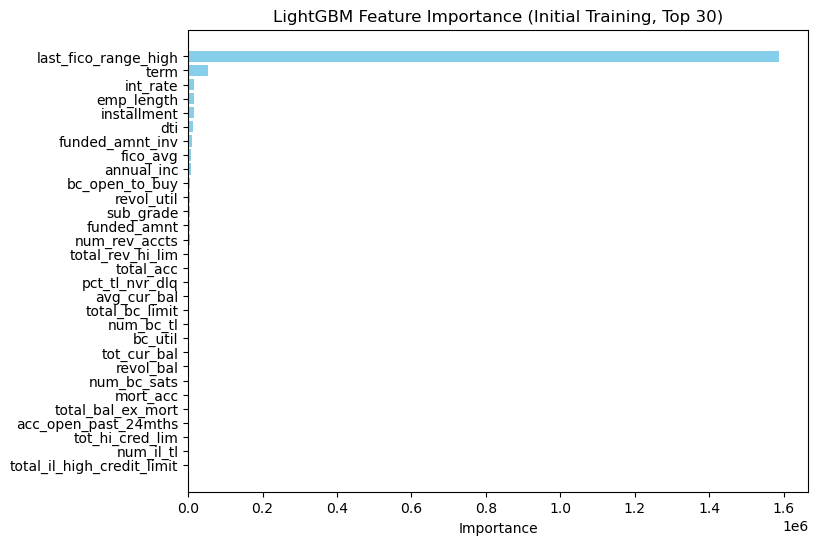

In [25]:
## feature importance visualization
def plot_feature_importance(df, title, color='skyblue'):
    plt.figure(figsize=(8, 6))
    plt.barh(df['Feature'], df['Importance'], color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance(df_top, "LightGBM Feature Importance (Initial Training, Top 30)")

### 다-2-2. Re-training

#### 다-2-2-1. training

In [26]:
## 01.feature importance dataframe 설정
def get_selected_features(lgb_model, domain_features=['dti', 'revol_util', 'fico_avg']):
    """
    Calculates feature importance, selects top features (including domain features),
    and returns the list of selected features.
    """
    ## 01. feature importance dataframe 설정
    lgb_importance_df = pd.DataFrame({
        'Feature': lgb_model.feature_name(),
        'Importance': list(lgb_model.feature_importance(importance_type='gain'))
    }).sort_values(by='Importance', ascending=False)

    ## 02. 도메인 feature 필터링 (데이터에 존재하는 것만)
    existing_domain_features = [
        feat for feat in domain_features if feat in lgb_importance_df['Feature'].values
    ]

    ## 03. 중요도 상위 feature (도메인 feature 제외)
    top_features = lgb_importance_df[
        ~lgb_importance_df['Feature'].isin(domain_features)  # 도메인 feature 제외
    ].head(30 - len(existing_domain_features))  # 최대 30 - (이미 선택된 도메인 feature 수) 개

    ## 04. 최종 feature 결합 (도메인 feature + 중요도 상위 feature)
    selected_features = existing_domain_features + top_features['Feature'].tolist()
    return selected_features

##  02 selected features 활용하여 새로운 X, y 만들기
def create_datasets_with_selected_features(X, y, selected_features, test_size=0.2, valid_size=0.25, random_state=42):
    """
    선택된 기능만으로 학습, 검증 및 테스트 데이터셋을 만든다.

    Args:
        X: Original feature DataFrame.
        y: Original target Series.
        selected_features: 선택된 기능 목록.
        test_size: 테스트 세트에 사용할 데이터의 비율
        valid_size: 검증에 사용할 훈련 데이터의 비율
                     (참고: 전체 유효 크기는 유효한_size * (1-검정_size))
        random_state: 재현성을 위한 랜덤 시드

    Returns:
      X_train, X_valid, X_test, y_train, y_valid, y_test
    """
    # X feature 선택
    if not all(feature in X.columns for feature in selected_features):
        missing_features = [feature for feature in selected_features if feature not in X.columns]
        raise ValueError(f"The following features are not present in X: {missing_features}")
    
    X_selected = X[selected_features]


    # Train/test split (initial split의 결과와 동일하게)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X_selected, y, test_size=test_size, random_state=random_state
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_temp, y_train_temp, test_size=valid_size, random_state=random_state
    )

    return X_train, X_valid, X_test, y_train, y_valid, y_test

## 03 XGBoost Model training 시키기
def train_lgboost_model(X_train, y_train, X_valid, y_valid, params=None, num_boost_round=500):
    """Trains an lgboost model with the given data and parameters."""

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    if params is None:
        params = {
            'objective': 'binary',          # 이진 분류
            'metric': 'binary_logloss',     # 평가 지표
            'seed': RANDOM_SEED
        }

    model = lgb.train(
                params,
                dtrain,
                num_boost_round=500,
                valid_sets=[dtrain, dvalid],
                valid_names=['train', 'valid'],
                callbacks=[lgb.early_stopping(stopping_rounds=10)]
            )
    return model


In [27]:
## selected features
selected_features = get_selected_features(lgb_model)


## selected features를 사용하여 새로운 train, val, test 만들기
X_train, X_valid, X_test, y_train, y_valid, y_test = create_datasets_with_selected_features(
    X, y, selected_features
)

# selected features를 사용해서 xgb train
new_lgb_model = train_lgboost_model(X_train, y_train, X_valid, y_valid)


[LightGBM] [Info] Number of positive: 118314, number of negative: 494506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5074
[LightGBM] [Info] Number of data points in the train set: 612820, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193065 -> initscore=-1.430217
[LightGBM] [Info] Start training from score -1.430217
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[154]	train's binary_logloss: 0.215415	valid's binary_logloss: 0.222914


#### 다-2-2-2. feature importance visualization

In [28]:
## Dataset 생성
new_lgb_importance_df = pd.DataFrame({
    'Feature': new_lgb_model.feature_name(),
    'Importance': new_lgb_model.feature_importance(importance_type='gain')
}).sort_values(by='Importance', ascending=False)

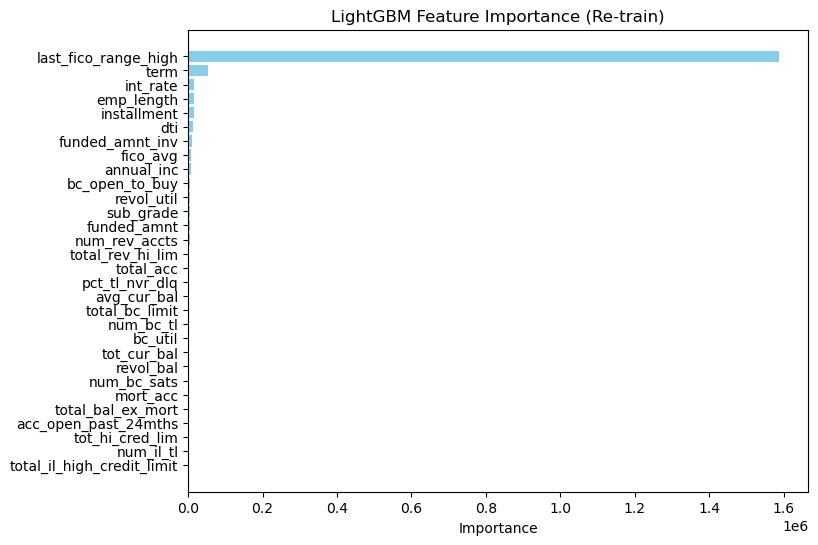

In [29]:
## feature importance visualization
def plot_feature_importance(df, title, color='skyblue'):
    plt.figure(figsize=(8, 6))
    plt.barh(df['Feature'], df['Importance'], color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance(new_lgb_importance_df, "LightGBM Feature Importance (Re-train)")

### 05-3. threshold 튜닝

In [30]:
# 테스트 데이터에 대한 예측 확률
X_test_for_prediction = X_test[selected_features]
y_pred_prob_lgb = lgb_model.predict(X_test)  # 클래스 1 (부도)에 대한 확률

# 목적 함수를 사용하여 최적 threshold 찾기
best_threshold_lgb, max_objective_lgb = custom_objective(y_test, y_pred_prob_lgb, earning_rate_test)


In [31]:
## 결과 확인
# 최적 임계치를 사용하여 최종 예측
print(f"Best Threshold: {best_threshold_lgb}")
print(f"Maximized Objective: {max_objective_lgb}")

# classification report
y_pred_final_lgb = (y_pred_prob_lgb >= best_threshold_lgb).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final_lgb))

# Confusion Matrix
conf_matrix_final_lgb = confusion_matrix(y_test, y_pred_final_lgb)
print("\nFinal Confusion Matrix (lightGBM):")
print("                 Predicted Negative (0)   Predicted Positive (1)")
print(f"Actual Negative (0)      {conf_matrix_final_lgb[0, 0]} (TN)             {conf_matrix_final_lgb[0, 1]} (FP)")
print(f"Actual Positive (1)      {conf_matrix_final_lgb[1, 0]} (FN)             {conf_matrix_final_lgb[1, 1]} (TP)")

print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_final_lgb)))

## 종합 평가지표 계산
accuracy = accuracy_score(y_test, y_pred_final_lgb)
precision = precision_score(y_test, y_pred_final_lgb)
recall = recall_score(y_test, y_pred_final_lgb)
f1 = f1_score(y_test, y_pred_final_lgb)

print("\nOverall Metrics:")
print("Accuracy:  {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall:    {:.4f}".format(recall))
print("F1 Score:  {:.4f}".format(f1))

Best Threshold: 0.6
Maximized Objective: 1740265.869999929

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    164891
           1       0.66      0.66      0.66     39383

    accuracy                           0.87    204274
   macro avg       0.79      0.79      0.79    204274
weighted avg       0.87      0.87      0.87    204274


Final Confusion Matrix (lightGBM):
                 Predicted Negative (0)   Predicted Positive (1)
Actual Negative (0)      151727 (TN)             13164 (FP)
Actual Positive (1)      13434 (FN)             25949 (TP)
Test Accuracy: 0.8698

Overall Metrics:
Accuracy:  0.8698
Precision: 0.6634
Recall:    0.6589
F1 Score:  0.6612


In [32]:
## 모델과 최적 임계치 저장 (모델과 threshold를 딕셔너리로 묶어서 저장)
model_dir = "./02 model"
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join(model_dir, "default_pred_lgb.pkl")

saved_obj = {
    "model": lgb_model,
    "best_threshold": best_threshold_lgb
}
joblib.dump(saved_obj, save_path)
print(f"Model and threshold saved to {save_path}")


Model and threshold saved to ./02 model/default_pred_lgb.pkl


## 06. 모델 선택 및 저장

In [33]:
## earning rate가 더 큰 모델 선택
if max_objective_xgb > max_objective_lgb:
    best_default_model = new_xgb_model
    best_threshold = best_threshold_xgb
    best_model_name = "xgboost"
    print("XGBoost selected as the best model.")
else:
    best_default_model = new_lgb_model
    best_threshold = best_threshold_lgb
    best_model_name = "lightgbm"
    print("LightGBM selected as the best model.")

XGBoost selected as the best model.


In [34]:
# 모델 저장
model_dir = "./02 model"
os.makedirs(model_dir, exist_ok=True)
if best_model_name == "xgboost":
    save_path = os.path.join(model_dir, "best_default_model.pkl")
    joblib.dump({'model': best_default_model, 'threshold': best_threshold}, save_path)

elif best_model_name == "lightgbm":
     save_path = os.path.join(model_dir, "best_default_model.pkl")
     joblib.dump({'model': best_default_model,
                 'best_iteration': best_default_model.best_iteration,
                 'threshold':best_threshold}, save_path)


print(f"Best model ({best_model_name}) and threshold saved to {save_path}")

Best model (xgboost) and threshold saved to ./02 model/best_default_model.pkl
